# ASTROGET

In [1]:
__author__ = 'Steve Pothier <steve.pothier@noirlab.edu>'
__version__ = '20230112' # yyyymmdd; 
__keywords__ = ['HowTo', 'astronomy', 'tutorial']

This notebook demonstrates using the `astroget` package to get metadata and pixel data from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/).

## Table of contents
* [Goals & Summary](#goalssummary)
* [Imports and setup](#imports)
* [Discover Images](#discover)
* [Get HDU](#gethdu)
* [Get cutout of object](#cutout)
* [Generate photo album](#album)
* [Find all Messier objects](#messier)
* [Save Messier snapshots](#save_album)

<a class="anchor" id="goals"></a>
## Goals & Summary 
Demonstrate the use of the `astroget` package to get metadata and pixel data from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/). 
- Discovery: Search for matching metadata and return metadata records.
- Find images containing regions of sky (SIA)
- Retrieve images
  + Full FITS file
  + Single HDU of FITS file
  + Cutout of rectangular region of one HDU of a FITS file (as a new FITS file)


<a class="anchor" id="imports"></a>
## Imports and Setup

In [2]:
from pprint import pformat as pf
import os.path
from importlib import reload
from collections import defaultdict
from datetime import datetime

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import pandas as pd

# %matplotlib inline
%matplotlib widget
plt.rcParams['font.size'] = 14

%cd ~/sandbox/astroget  
import astroget.client

/home/pothiers/sandbox/astroget


<a class="anchor" id="install"></a>
## Install the most recent version of the `astroget`:
*NOTE: After installing the most recent version, please restart your kernel.*

In [3]:
# !!! To run local version of astroget
%cd ~/sandbox/astroget  
%pwd

from astroget.utils import tic,toc
# !pip install -U astroget
import astroget.client
reload(astroget.client)
astroget.__version__

/home/pothiers/sandbox/astroget


'0.1.0b1.dev1'

In [4]:
print(f'Run started: {str(datetime.now())}')
#server='https://astroarchive.noirlab.edu'
server='https://marsnat1-pat.csdc.noirlab.edu' # Server must support client.cutout() method !!!
client = astroget.client.CsdcClient(url=server)
client

Run started: 2023-02-01 06:11:44.749479


(astroget:0.1.0b1.dev1, api:6.0, https://marsnat1-pat.csdc.noirlab.edu/api, verbose=False, connect_timeout=3.05, read_timeout=300.0)

# Basic Use of `astroget` for Cutouts
- Discover list of HDUs that contain pixels we want
  + get/display some metadata in pandas
  + retrieve/display a full matching HDU
- Cutout from HDU and display
- Cutout subimages from multiple HDUs and save FITS (appropriately named)

<a class="anchor" id="discover"></a>
## Find image/HDU of an object
Get position from name. Use additional constraints on the FITS files selected.
Display one of them.

In [5]:
# Discover image(s) of object
#fname='/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_050615_oow_r_v1.fits.fz'
obj_name = 'M65' #65,(77,96)
obj_coord = SkyCoord.from_name(obj_name)
ra = obj_coord.ra.degree
dec = obj_coord.dec.degree

# default search using Overlap (essentially Postgres "&&" range operator)
# Use very small size to approximate "obj center in HDU"
search_size = 0.0001 # radius in degrees

found = client.vohdu((ra,dec), search_size,  # position=(ra,dec), size(in decimal degrees)
            instrument='decam', obs_type='object', proc_type='instcal',
            VERB=3, limit=None, verbose=False)

print(f'Found {found.count} matches of object {obj_name} at position: ra,dec={(ra,dec)} using client.vohdu()')

Found 1 matches of object M65 at position: ra,dec=(169.73295193949, 13.09230575102) using client.vohdu()


In [6]:
recidx = 0
rec = found.records[recidx]
print(f'Show 1 of {found.count} records. rec[{recidx}] = ')
print(f'{pf(rec)}')

md5 = rec['md5sum']
hduidx = rec['hdu_idx']
hduurl = rec['url']  

Show 1 of 1 records. rec[0] = 
{'archive_filename': '/net/archive/pipe/20180317/ct4m/2014B-0404/c4d_180318_042948_oow_r_v2.fits.fz',
 'dec_center': 13.11109,
 'exposure': 55.0,
 'file_caldat': '2018-03-17',
 'file_dateobs': '2018-03-18 04:30:15.550606+00',
 'file_release_date': '2019-09-08',
 'file_updated': '2020-10-27 22:05:11.876725+00',
 'filesize': 320935680,
 'filter': 'r DECam SDSS c0002 6415.0 1480.0',
 'hdu_idx': 22,
 'instrument': 'decam',
 'md5sum': '42f1686ad501db310de073a95f064a7e',
 'obs_type': 'object',
 'original_filename': '/data_local/images/dts/2014b-0404/decam_00731496.fits.fz',
 'proc_type': 'instcal',
 'prod_type': 'wtmap',
 'proposal': '2014B-0404',
 'ra_center': 169.7432,
 'telescope': 'ct4m',
 'url': 'https://marsnat1-pat.csdc.noirlab.edu/api/retrieve/42f1686ad501db310de073a95f064a7e/?hdus=0,23'}


<a class="anchor" id="gethdu"></a>that
## Get and Display one HDU we found

HDU size in pixels = (4094, 2046)


REQ18B_BIGGAL_9304d42-r-20180318T042948_oi[S12,noinherit][2046,4094][real]: DECa [astropy.io.fits.card]


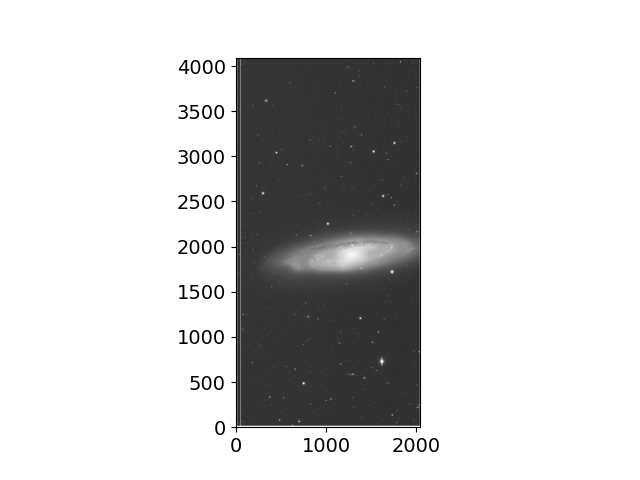

In [7]:
# Make sure archive file is valid.  Normally this will always be true, but we 
# are recovering from a "mass storage" outage.
assert client.fitscheck(md5)['valid'], f"Invalid FITS file {rec['archive_filename']}"

# Image might be prioprietary. If so, using api/retrieve URL will error. 
# (But its possible to provide credentials...)
# API should provide more helpful error messages for exceptions: timeout, proprietary !!!
header0 = fits.getheader(hduurl, 0) # hdu0=Primary, hdu1=image
image_data1, header1 = fits.getdata(hduurl, 1, header=True) # hdu0=Primary, hdu1=image
print(f'HDU size in pixels = {image_data1.shape}')

%matplotlib widget
plt.imshow(image_data1, origin='lower', cmap='gray_r')

<a class="anchor" id="cutout"></a>
## Cutout subimage from HDU

Get subimage centered at ra,dec=(169.73295193949, 13.09230575102) size 800. From image md5,hduidx=(42f1686ad501db310de073a95f064a7e, 22)
cutout url=https://marsnat1-pat.csdc.noirlab.edu/api/cutout/42f1686ad501db310de073a95f064a7e?ra=169.73295193949&dec=13.09230575102&size=800&hduidx=23
subimage as been cutout into local FITS file: subimage_42f1686ad501db310de073a95f064a7e_169_13.fits


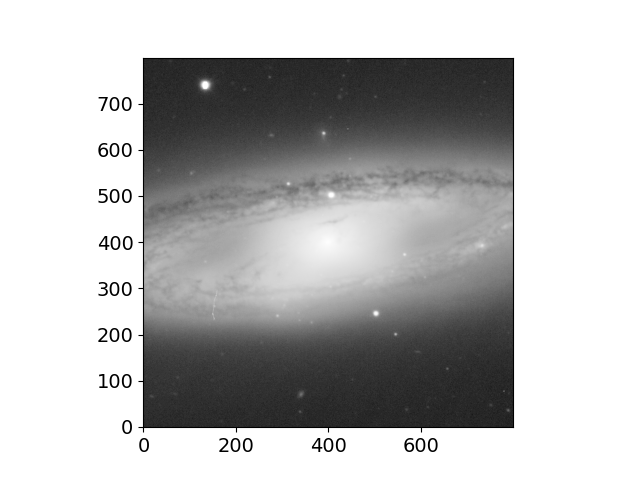

In [8]:
subimage_size = 800
print(f'Get subimage centered at ra,dec={(ra,dec)} size {subimage_size}. From image md5,hduidx=({md5}, {hduidx})')
# get FITS file
subimage = client.cutout(ra, dec, subimage_size, md5, hduidx, verbose=True)
print(f'subimage as been cutout into local FITS file: {subimage}')

image_data = fits.getdata(subimage)
plt.figure()
plt.imshow(image_data, origin='lower', cmap='gray_r')

<a class="anchor" id="album"></a>
# Generate astronomy photo album
Given a list of astro objects, find images that contain them and extract a subimage of the object. We don't know how big the objects are so all subimages are the same size. That size might be too big or too small.

In [9]:
assert False, 'Do not automatically continue beyond here' #!!!

AssertionError: Do not automatically continue beyond here

<a class="anchor" id="messier"></a>
## Find All Images (HDUs)for Messier objects in the Astro Data Archive
For each object name: get its position and search full archive for HDUs that overlap a box around the object position. All 393 mil(26 mil) HDUs are searched.

In [15]:
%%time
albumdir = os.path.expanduser('~/astro-album/')
search_size = 0.0001 # radius in degrees
subimage_size = 800 # square pixels

objs = defaultdict(list)
for n in range(1,110+1):
    name = f'M{n}'
    obj_coord = SkyCoord.from_name(name)
    ra = obj_coord.ra.degree
    dec = obj_coord.dec.degree
    
    found = client.vohdu((ra,dec), search_size, VERB=3, 
                        instrument='decam', obs_type='object', proc_type='instcal',
                        limit=None)
    print(f'Found {found.count} "{name}" objects',end='. ')
    print
    for rec in found.records:
        objs[name].append(rec)
files = set([(r['md5sum'],r['archive_filename']) for obrecs in objs.values() for r in obrecs])
print(f'\n\nFound at least one HDU for objects: {[k for k,v in objs.items() if len(v) > 0]}')

Found 0 "M1" objects. Found 9 "M2" objects. Found 0 "M3" objects. Found 0 "M4" objects. Found 0 "M5" objects. Found 1 "M6" objects. Found 0 "M7" objects. Found 0 "M8" objects. Found 0 "M9" objects. Found 3 "M10" objects. Found 0 "M11" objects. Found 0 "M12" objects. Found 0 "M13" objects. Found 0 "M14" objects. Found 10 "M15" objects. Found 0 "M16" objects. Found 0 "M17" objects. Found 0 "M18" objects. Found 0 "M19" objects. Found 0 "M20" objects. Found 0 "M21" objects. Found 0 "M22" objects. Found 0 "M23" objects. Found 0 "M24" objects. Found 1 "M25" objects. Found 0 "M26" objects. Found 0 "M27" objects. Found 0 "M28" objects. Found 0 "M29" objects. Found 0 "M30" objects. Found 0 "M31" objects. Found 0 "M32" objects. Found 0 "M33" objects. Found 0 "M34" objects. Found 0 "M35" objects. Found 0 "M36" objects. Found 0 "M37" objects. Found 0 "M38" objects. Found 0 "M39" objects. Found 0 "M40" objects. Found 1 "M41" objects. Found 2 "M42" objects. Found 2 "M43" objects. Found 0 "M44" objec

In [16]:
badfiles = {'/net/archive/pipe/20130910/ct4m/2012B-0001/c4d_130911_034852_ooi_i_d2.fits.fz',
 '/net/archive/pipe/20131220/ct4m/2012B-0001/c4d_131221_034320_ooi_Y_d2.fits.fz',
 '/net/archive/pipe/20160923/ct4m/2012B-0001/c4d_160924_064533_oow_r_v2.fits.fz',
 '/net/archive/pipe/20170331/ct4m/2014B-0404/c4d_170401_020257_oow_r_v1.fits.fz',
 '/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_042238_ooi_z_v1.fits.fz',
 '/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_050032_ooi_z_v1.fits.fz',
 '/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_050615_oow_r_v1.fits.fz',
 '/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_052823_ooi_i_v1.fits.fz',
 '/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_074416_oow_u_v1.fits.fz',
 '/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_075609_ooi_Y_v1.fits.fz',
 '/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_083316_ooi_r_v1.fits.fz',
 '/net/archive/pipe/20170803/ct4m/2017B-0951/c4d_170804_083353_oow_i_v1.fits.fz',
 '/net/archive/pipe/20170804/ct4m/2017B-0951/c4d_170805_032236_ooi_g_v1.fits.fz',
 '/net/archive/pipe/20170804/ct4m/2017B-0951/c4d_170805_052620_ooi_Y_v1.fits.fz',
 '/net/archive/pipe/20170804/ct4m/2017B-0951/c4d_170805_054035_ooi_Y_v1.fits.fz',
 '/net/archive/pipe/20170804/ct4m/2017B-0951/c4d_170805_080110_ooi_Y_v1.fits.fz',
 '/net/archive/pipe/20170804/ct4m/2017B-0951/c4d_170805_083105_ooi_r_v1.fits.fz',
 '/net/archive/pipe/20170805/ct4m/2017B-0951/c4d_170806_044016_oow_Y_v1.fits.fz',
 '/net/archive/pipe/20171228/ct4m/2017B-0078/c4d_171229_080213_ood_i_v1.fits.fz',
 '/net/archive/pipe/20180317/ct4m/2014B-0404/c4d_180318_061320_oow_r_v1.fits.fz',
 '/net/archive/pipe/20180328/ct4m/2018A-0159/c4d_180329_042613_oow_u_v1.fits.fz',
 '/net/archive/pipe/20180328/ct4m/2018A-0159/c4d_180329_062223_ooi_r_v1.fits.fz',
 '/net/archive/pipe/20180328/ct4m/2018A-0159/c4d_180329_075359_oow_z_v1.fits.fz',
 '/net/archive/pipe/20180416/ct4m/2018A-0909/c4d_180417_062023_ooi_N662_v1.fits.fz',
 '/net/archive/pipe/20180418/ct4m/2018A-0206/c4d_180419_061753_ooi_r_v1.fits.fz',
 '/net/archive/pipe/20180419/ct4m/2018A-0159/c4d_180420_100240_oow_z_v1.fits.fz',
 '/net/archive/pipe/20180419/ct4m/2018A-0206/c4d_180420_074054_ooi_i_v1.fits.fz',
 '/net/archive/pipe/20180429/ct4m/2018A-0159/c4d_180430_083543_ooi_r_v1.fits.fz',
 '/net/archive/pipe/20180501/ct4m/2018A-0159/c4d_180502_051028_oow_i_v1.fits.fz',
 '/net/archive/pipe/20180504/ct4m/2018A-0159/c4d_180505_055403_oow_u_v1.fits.fz',
 '/net/archive/pipe/20180505/ct4m/2018A-0206/c4d_180506_055006_oow_r_v1.fits.fz',
 '/net/archive/pipe/20180523/ct4m/2018A-0206/c4d_180524_002342_oow_g_v1.fits.fz',
 '/net/archive/pipe/20180618/ct4m/2018A-0206/c4d_180619_021606_ooi_r_v1.fits.fz',
 '/net/archive/pipeline/Q20150425/DEC15A/20150407/c4d_150410_033027_ooi_z_v1.fits.fz',
 '/net/archive/pipeline/Q20150617/DEC15A/20150611/c4d_150613_092917_ooi_g_v1.fits.fz',
 '/net/archive/pipeline/Q20150719/DEC15A/20150714/c4d_150715_071229_ood_g_v1.fits.fz',
 '/net/archive/pipeline/Q20150918/REQ13B/HETDEX/c4d_131215_034511_oow_Y_v2.fits.fz',
 '/net/archive/pipeline/Q20160104/DEC15B/20151229/c4d_151230_063527_ood_i_v1.fits.fz',
 '/net/archive/pipeline/Q20160105/DEC15B/20151229/c4d_151230_053314_ood_r_v1.fits.fz',
 '/net/archive/pipeline/Q20160302/DEC16A/20160225/c4d_160302_022120_oow_g_v1.fits.fz',
 '/net/archive/pipeline/Q20160907/DEC16B/20160831/c4d_160906_034258_oow_VR_v1.fits.fz',
 '/net/archive/pipeline/Q20170111/DEC16B/20170102/c4d_170107_080204_oow_z_v1.fits.fz',
 '/net/archive/pipeline/Q20170111/DEC16B/20170102/c4d_170107_081751_oow_u_v1.fits.fz',
 '/net/archive/pipeline/Q20170111/DEC16B/20170102/c4d_170108_081653_oow_u_v1.fits.fz'}

In [17]:
len(badfiles), len(files)

(44, 84)

<a class="anchor" id="save_album"></a>
## Save local subimages for all Messier objects we found
Store all FITS subimates in a single directory using a file name that contains the Messier object name.
Each `client.cutout()` call makes a web-service call which: reads the HDU image data and metadata, extracts the cutout into a new tempory FITS file that contains the original Primary HDU and Extension=1 HDU that contains the submage (with WCS), and streams the temporary file in the HTTP response.  The client reads the response and saves it to a local file.

In [ ]:
%%time
aa = '~/astro-album/'
albumdir = os.path.expanduser(aa)
count = 0
tic()
for name,v in objs.items():
    total = len(v)
    for idx,rec in enumerate(v):
        print(f'Create cutout for {name}[{idx}/{total}]', end='...')
        
        #!if name=='M2' and idx==3:
        #!    continue
        if rec['archive_filename'] in badfiles:
            print('skipped', end='...')
            continue

        obj_coord = SkyCoord.from_name(name)
        ra = obj_coord.ra.degree
        dec = obj_coord.dec.degree
        outfile = f'{albumdir}/subimage_{name}_{idx}.fits'
        try:
            client.cutout(ra, dec, subimage_size, 
                          #rec['url'], 
                          rec['md5sum'], rec['hdu_idx'],
                          outfile=outfile)
            count += 1
        except Exception as err:
            print(f'\nFailed cutout for {name}[{idx}]; {err}')
            continue
elapsed = toc()
print('All Done!\n')
print(f'Created and retrieved {count} cutouts in {elapsed:0.2f} seconds. ({count/elapsed:0.1f} cutouts/sec)') # 0.4
#!print(f'You might want to view all files {aa} in  with QFitsView and turn on "blink" to get a slide show.')
print(f'\nYou might want to view all files in {aa} with ds9 (SAOImageDS9) and turn on "blink" to get a slide show.'
      f'\n  EXAMPLES: '
      f'\n  ds9 {aa}*.fits -blink'
      f'\n  ds9 {aa}*.fits -blink interval 0.1 -blink  # one frame every 0.1 seconds\n'
     )

Create cutout for M2[0/9]...skipped...Create cutout for M2[1/9]...skipped...Create cutout for M2[2/9]...skipped...Create cutout for M2[3/9]...skipped...Create cutout for M2[4/9]...skipped...Create cutout for M2[5/9]...skipped...Create cutout for M2[6/9]...skipped...Create cutout for M2[7/9]...skipped...Create cutout for M2[8/9]...Create cutout for M6[0/1]...Create cutout for M10[0/3]...Create cutout for M10[1/3]...Create cutout for M10[2/3]...Create cutout for M15[0/10]...skipped...Create cutout for M15[1/10]...skipped...Create cutout for M15[2/10]...skipped...Create cutout for M15[3/10]...skipped...Create cutout for M15[4/10]...skipped...Create cutout for M15[5/10]...skipped...Create cutout for M15[6/10]...Create cutout for M15[7/10]...skipped...Create cutout for M15[8/10]...Create cutout for M15[9/10]...Create cutout for M25[0/1]...skipped...Create cutout for M41[0/1]...skipped...Create cutout for M42[0/2]...skipped...Create cutout for M42[1/2]...skipped...Create cutout for M43[0/2].

In [ ]:
!ds9 {aa}*.fits -blink interval 0.2 -blink